In [1]:
import qutip as qt 
import numpy as np
import matplotlib.pyplot as plt
import math 
from scipy.optimize import minimize

import os
os.chdir('/Users/ngdnhtien/Codespace/bqec@huikhoon')

%config InlineBackend.figure_formats = ['svg']

# Pertubative expression for $K_B$

In [2]:
def full_KB(del_bqb, del_dqb, amp_dqb_sq, gb_qb, dim=30, m=0):
    """
        Calculate Kerr nonlinearities cavity mode B inherited 
        when capacitively coupled to the transmon qb. 

        Args:
            delta_bqb: cavity B transmon qb detuning
            delta_dqb: drive d transmon qb detuning
            amp_dqb_sq: square-rooted value of drive amplitude/drive detuning on qb
            gb_qb: cavity B transmon qb coupling strength
        Return:
            NB: photon number on mode B (real)
            KB: corresponding cavity B nonlinearities
    """

    global alpha_qb, om_qb10, om_qb, om_dqb, Amp_dqb, g_bqb, om_b
    
    alpha_qb = 2*np.pi*0.125 # changed from 0.119 
    om_qb10 = 2*np.pi*(5.599 - 0.400) # +0.3 GHz detuned from the central Ymon, can be changed to another value >=|0.3|
    
    om_qb = om_qb10 + alpha_qb
    om_dqb = om_qb10 + del_dqb*alpha_qb # om_dqb = om_qb10 + del_dqb?
    Amp_dqb = np.sqrt(amp_dqb_sq)*abs(del_dqb)*alpha_qb
    del_dqbqb = om_dqb - om_qb
    H_qb = -del_dqbqb*qt.create(dim)*qt.destroy(dim) - (alpha_qb/2)*(qt.create(dim)*qt.destroy(dim)+1)*qt.create(dim)*qt.destroy(dim) + Amp_dqb*qt.create(dim) + np.conj(Amp_dqb)*qt.destroy(dim)

    g_bqb = -1j*gb_qb*abs(del_bqb)*alpha_qb
    om_b = om_qb10 + del_bqb*alpha_qb
    del_dqbb = om_dqb - om_b
    
    global eigen

    eigval_qb, eigvec_qb = H_qb.eigenstates(sort='high')
    eigen = []    
    for v in range(len(eigvec_qb)):
        eigen.append([eigval_qb[v], eigvec_qb[v]])
    del eigval_qb, eigvec_qb
    
    def Eqb_mn(n):
        return eigen[m][0]-eigen[n][0]
    
    def qb_inm(i,p,q):
        if i==1:
            return (eigen[p][1].dag()*qt.create(dim)*eigen[q][1])[0,0]
        elif i==-1:
            return (eigen[p][1].dag()*qt.destroy(dim)*eigen[q][1])[0,0]

    def M_cija(n,i,j):
        return np.sum([qb_inm(i,n,q)*qb_inm(j,q,m)/((eigen[m][0]-eigen[q][0])-j*del_dqbb) for q in range(dim)])
    def N_cija(n,i,j):
        return np.sum([qb_inm(i,n,q)*qb_inm(j,q,m)/((eigen[m][0]-eigen[q][0])-j*del_dqbb)**2 for q in range(dim)])
    
    NB_1 = np.nansum([-abs(M_cija(x,1,1))**2/(Eqb_mn(x)-2*del_dqbb)+3*abs(M_cija(x,-1,-1))**2/(Eqb_mn(x)+2*del_dqbb) for x in range(dim)]) + np.nansum([(abs(M_cija(x,1,-1))**2+abs(M_cija(x,-1,1))**2)/Eqb_mn(x) for x in range(dim) if x != m]) + 2*np.nansum([np.sum([qb_inm(1,m,q)*qb_inm(-1,q,x)/(Eqb_mn(q)+del_dqbb) for q in range(dim)])*M_cija(x,1,-1) for x in range(dim) if x != m])
    NB_neg = -(abs(g_bqb)**2*M_cija(m,1,-1)) - (abs(g_bqb)**2*N_cija(m,1,-1))*(abs(g_bqb)**2*(M_cija(m,1,-1)+M_cija(m,-1,1)))
    NB = abs(g_bqb)**2*(M_cija(m,1,-1)+M_cija(m,-1,1)) + np.nansum([abs(g_bqb)**4*NB_1, NB_neg])
    
    KB_1 = np.nansum([abs(M_cija(x,1,1))**2/(Eqb_mn(x)-2*del_dqbb)+abs(M_cija(x,-1,-1))**2/(Eqb_mn(x)+2*del_dqbb) for x in range(dim)]) + np.nansum([abs(M_cija(x,1,-1)+M_cija(x,-1,1))**2/Eqb_mn(x) for x in range(dim) if x != m])
    KB_neg = -(abs(g_bqb)**2*(M_cija(m,1,-1)+M_cija(m,-1,1)))*(abs(g_bqb)**2*(N_cija(m,1,-1)+N_cija(m,-1,1)))
    KB = np.nansum([abs(g_bqb)**4*KB_1, KB_neg])
    
    return np.real(NB), np.real(KB)

### Execution

In [3]:
NB_calc, KB_calc = full_KB(del_bqb=(4.626*0.115)/0.119 + 0.400/0.119, # cavity-transmon detuning
                           del_dqb=-1.25, # drive-transmon detuning
                           amp_dqb_sq=0., # drive-transmon amplitude squared
                           gb_qb=0.03) # cavity-transmon coupling strength

alpha_qb, om_qb10, om_qb, om_dqb, Amp_dqb, g_bqb, om_b

print('alpha_qb = ', alpha_qb/(2*np.pi))
print('om_qb = ', om_qb/(2*np.pi))
print('om_qb10 = ', om_qb10/(2*np.pi))
print('om_dqb = ', om_dqb/(2*np.pi))
print('Amp_dqb = ', Amp_dqb/(2*np.pi))
print('om_B = ', om_b/(2*np.pi))
print('g_bqb = ', g_bqb/(2*np.pi))
print('Semi-analytical', [NB_calc, KB_calc])

alpha_qb =  0.125
om_qb =  5.323999999999999
om_qb10 =  5.199
om_dqb =  5.04275
Amp_dqb =  0.0
om_B =  6.177981092436975
g_bqb =  -0.029369432773109248j
Semi-analytical [0.01319935360908457, 2.352374825651549e-08]


## A two-dimensional sweep [Amplitude 0, 1] [Detuning 0.1, 0.5, -0.1, -0.5]

In [4]:
# large_amps = np.linspace(0, 1, 26)
blue_detunings = np.linspace(0.1, 0.5, 25) # |0.1| smallest

In [5]:
blue_detunings

array([0.1       , 0.11666667, 0.13333333, 0.15      , 0.16666667,
       0.18333333, 0.2       , 0.21666667, 0.23333333, 0.25      ,
       0.26666667, 0.28333333, 0.3       , 0.31666667, 0.33333333,
       0.35      , 0.36666667, 0.38333333, 0.4       , 0.41666667,
       0.43333333, 0.45      , 0.46666667, 0.48333333, 0.5       ])

In [5]:
large_amps = np.linspace(0, 1, 26)
blue_detunings = np.linspace(0.1, 0.5, 25) # |0.1| smallest

KBs_blue_large_amp = np.zeros(len(large_amps))

for idx_a, amp in enumerate(large_amps):
    _, kb = full_KB(del_bqb=(4.626*0.115)/0.119 + 0.400/0.119, del_dqb=1.25, amp_dqb_sq=amp, gb_qb=0.05)
    KBs_blue_large_amp[idx_a] = kb

In [6]:
# KBs_blue_large_amp = np.load('./self_Kerr/KBs_blue_large_amp.pkl', allow_pickle=True)

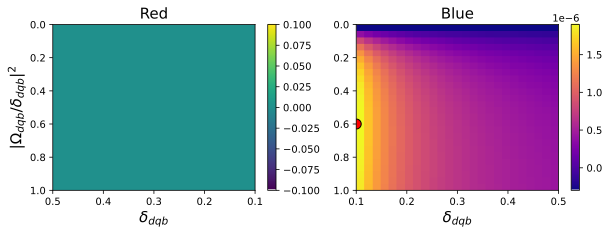

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import numpy as np

a3 = np.zeros([26, 25])
a4 = KBs_blue_large_amp

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

cax1 = ax1.imshow(a3, aspect='auto', cmap='viridis', extent = [max(blue_detunings), min(blue_detunings), max(large_amps) , min(large_amps)])
ax1.set_title('Red', fontsize=15)
ax1.set_ylabel(r'$|\Omega_{dqb}/\delta_{dqb}|^2$', fontsize=15)
ax1.set_xlabel(r'$\delta_{dqb}$', fontsize=15)
fig.colorbar(cax1, ax=ax1)

cax2 = ax2.imshow(a4, aspect='auto', cmap='plasma', extent = [min(blue_detunings), max(blue_detunings), max(large_amps) , min(large_amps)])
ax2.set_title('Blue', fontsize=15)
ax2.set_xlabel(r'$\delta_{dqb}$', fontsize=15)
fig.colorbar(cax2, ax=ax2)
max_value_index_a4 = np.unravel_index(np.argmax(np.abs(a4)), a4.shape)
ax2.scatter(blue_detunings[max_value_index_a4[1]], large_amps[max_value_index_a4[0]], color='red', s=100, edgecolors='black')

plt.show()
plt.tight_layout()

In [7]:
import pickle
with open('./self_Kerr/KBs_blue_large_amp_1D.pkl', 'wb') as f:
    pickle.dump(KBs_blue_large_amp, f)

# Numerical simulation

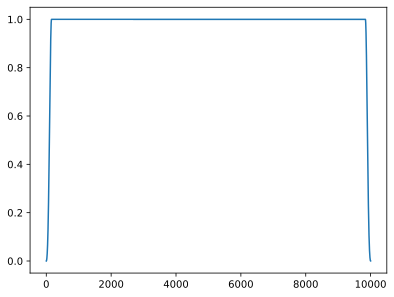

In [8]:
def compute_alpha(r1):
    return 1/np.abs(r1)

def staticHamiltonian(a_op, c_op, omega_a, omega_c, alpha, g_ac):
    """ 
        Construct the Hamiltonian for the given set of parameters
        The `a_op` and `c_op` are the annihilation of the respective mode `a` and `c` 
        Because it is dimension-dependent, they are taken as inputs of the Hamiltonian.
        The rest are parameters.
    """

    EC = alpha
    EJ = omega_c**2/(8*alpha)

    n_op = -1j * (8*EC/EJ)**(-1/4) * (c_op-c_op.dag())/np.sqrt(2)
    phi_op = (8*EC/EJ)**(1/4) * (c_op+c_op.dag())/np.sqrt(2)

    H_cav = omega_a * a_op.dag() * a_op
    H_anc = 4 * EC * n_op**2 - EJ * phi_op.cosm()
    H_int = 1j * np.abs(np.real(g_ac)) * (c_op - c_op.dag()) * (a_op + a_op.dag()) # plus i: DONE
    H_static = H_cav + H_anc + H_int

    return H_cav, H_anc, H_int, H_static

def dressed_coherent(alpha, dimCavity, ordered_labelled_coupled_states):
    """
        Construct a coherent state
    """

    state = 0
    for n in range(dimCavity):
        state += (alpha**n)*ordered_labelled_coupled_states[n]/np.sqrt(float(math.factorial(n)))
    state = np.exp(-np.abs(alpha)**2/2)*state
    
    return state.unit()

T = 10000 #ns
times = np.linspace(0,T,T+1)

def ftb(t):
    t_start = times[0]
    t_stop = times[-1]
    t_rise = 160
    t_fall = 160
    def blackman(t, t_start, t_stop, a=0.16):
        def box(t, t_start, t_stop):
            if t < t_start:
                return 0.0
            if t > t_stop:
                return 0.0
            return 1.0
        T = t_stop - t_start
        box_vec = np.vectorize(box)
        return (0.5* box_vec(t, t_start, t_stop)* (1.0 - a - np.cos(2.0 * np.pi * (t - t_start) / T) + a * np.cos(4.0 * np.pi * (t - t_start) / T)))
    if t_start <= t <= t_stop:
        f = 1.0
        if t <= t_start + t_rise:
            f = blackman(t, t_start, t_start + 2 * t_rise)
        elif t >= t_stop - t_fall:
            f = blackman(t, t_stop - 2 * t_fall, t_stop)
        return f
    else:
        return 0.0

plt.plot(times,[ftb(t) for t in times])

In [11]:
amp_swept = np.arange(0, 1, 0.12)

amp_swept

array([0.  , 0.12, 0.24, 0.36, 0.48, 0.6 , 0.72, 0.84, 0.96])

In [215]:
r1=((4.6261*0.115)/0.119 + 0.400/0.119)
r2=0.05
r3=1.25

#########
r4=0.96##
#########

omega_c=5.324
alpha=0.125

dimTransmon = 15
dimCavity = 20

omega_10 = omega_c - alpha
delta_ac = r1 * alpha 
g_ac = r2 * delta_ac 
delta_dc = r3 * alpha
Omega_d = np.sqrt(r4) * np.abs(delta_dc)

omega_a = omega_10 + delta_ac
omega_d = omega_10 + delta_dc

a_op = qt.tensor(qt.qeye(dimTransmon), qt.destroy(dimCavity))
c_op = qt.tensor(qt.destroy(dimTransmon), qt.qeye(dimCavity))

H_cav, H_anc, H_int, H_static = staticHamiltonian(a_op, c_op, omega_a, omega_c, alpha, g_ac)

H_uncoupled = H_cav + H_anc

basis_state = []

for NC in range(dimTransmon):
    for NA in range(dimCavity):
        basis_state.append([qt.tensor(qt.basis(dimTransmon, NC), qt.basis(dimCavity, NA)), [NC, NA]])

_, uncoupled_eig_states = H_uncoupled.eigenstates()

labelled_prod_states = []

for eig_state in uncoupled_eig_states:
    max_fidelity = 0
    for state in basis_state:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_prod_states.append([eig_state, label_eig_state])

H_coupled = H_uncoupled + H_int
_, coupled_eig_states = H_coupled.eigenstates()

labelled_coupled_states = []

for eig_state in coupled_eig_states:
    max_fidelity = 0
    for state in labelled_prod_states:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_coupled_states.append([eig_state, label_eig_state])

ordered_labelled_coupled_states = []
for NA in range(dimCavity):
    for state in labelled_coupled_states:
        if state[1][0] == 0 and state[1][1] == NA:
            ordered_labelled_coupled_states.append(state[0])

NA_op = 0

for NA in range(dimCavity):
    NA_op += NA * ordered_labelled_coupled_states[NA] * ordered_labelled_coupled_states[NA].dag()

psi0_dressed = dressed_coherent(1.5, dimCavity, ordered_labelled_coupled_states)

def H_eff(t, args):
    return -Omega_d*ftb(t)*np.exp(-1j*2*np.pi*omega_d*t)+np.conj(Omega_d)*ftb(t)*np.exp(1j*omega_d*2*np.pi*t) # There's a minus sign: Done

H_full = [H_static*(2*np.pi), [(2*np.pi)*(c_op - c_op.dag()), H_eff]]

T = 5000
times = np.linspace(0,T,T+1)

res = qt.mesolve(H_full, psi0_dressed, times, progress_bar=True, options=qt.Options(nsteps=20000))

10.0%. Run time:  48.73s. Est. time left: 00:00:07:17
20.0%. Run time:  82.32s. Est. time left: 00:00:05:28
30.0%. Run time: 114.62s. Est. time left: 00:00:04:27
40.0%. Run time: 148.93s. Est. time left: 00:00:03:43
50.0%. Run time: 182.35s. Est. time left: 00:00:03:02
60.0%. Run time: 216.90s. Est. time left: 00:00:02:24
70.0%. Run time: 250.40s. Est. time left: 00:00:01:47
80.0%. Run time: 284.12s. Est. time left: 00:00:01:11
90.0%. Run time: 318.55s. Est. time left: 00:00:00:35
Total run time: 364.31s


# Fourth-order fit

In [216]:
def H4_eff(c0, c1, c2, c3):
    return (2*np.pi)*((omega_a+c0)*NA_op + c1 * NA_op**2 + c2 * NA_op**3 + c3 * NA_op**4)

def objective4(args):

    c0, c1, c2, c3 = args 

    evol_state = ((-1j*H4_eff(c0, c1, c2, c3)*times[-1]).expm() * psi0_dressed).unit()
    infd = np.abs(1 - qt.fidelity(evol_state, res.states[-1]))
    print(infd)
    return infd

x0 = [-5e-4, -1e-7, 1e-8, 1e-9]
solution4 = minimize(objective4, x0, method='Nelder-Mead', tol=1e-7)
self_Kerr = solution4.x[1]
print(self_Kerr)

0.9042546481125724
0.505170731610402
0.9042291791906195
0.9042369281506175
0.9042436049827777
0.7684477758469885
0.6530549666033816
0.42124080149982224
0.07483050061713659
0.0023227179917055807
0.4294367738519189
0.022337939892199454
0.2500832124945014
0.6220514233857748
0.13437102175398918
0.4826918054019862
0.04058650067309699
0.1411399200183474
0.03428130676555041
0.10696732869988756
0.015456864089136935
0.09021775441132718
0.006022959256104743
0.0446345857116498
0.0075827341962318995
0.05615702108372167
0.0029969200246762195
0.015000294959023663
0.0039126915256839645
0.024642399171345475
0.0008531030393786887
0.0032436156914767977
0.00968298758162578
0.0006818141671290912
0.0034195606391845823
0.000961179744797036
0.008462929300848465
0.0005132124838603813
0.0017433795201835522
0.0005467507688434736
0.0020359176869011453
0.0003240629765906
0.0025196750658197375
0.00027714510162835104
0.0003859677806388184
0.0007893405456247393
0.0002876880335963561
0.000983610729701101
0.0002655772

In [217]:
solution4.x

array([-5.51312355e-04, -3.25261883e-08,  1.68937876e-08,  1.78343699e-09])

In [173]:
avg_state_fid_4 = 0

for idx, state in enumerate(res.states[::99]):
    evol_state = ((-1j*H4_eff(solution4.x[0], solution4.x[1], solution4.x[2], solution4.x[3])*times[idx]).expm() * psi0_dressed).unit()
    avg_state_fid_4 += qt.fidelity(state, evol_state)

avg_state_fid_4 = avg_state_fid_4/len(res.states[::99])
print(avg_state_fid_4)

0.2665355386490636


Text(0.5, 1.0, '0.01437709617204027')

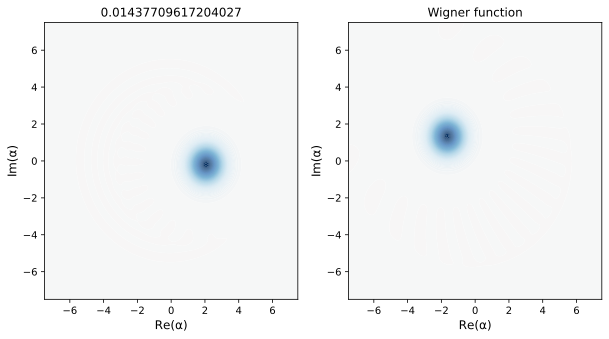

In [174]:
idx = 150

evol_state = ((-1j*H4_eff(solution4.x[0], solution4.x[1], solution4.x[2], solution4.x[3])*times[idx]).expm() * psi0_dressed).unit()
fidelity = qt.fidelity(evol_state, res.states[idx])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

qt.plot_wigner(res.states[idx].ptrace(1), ax=ax1, fig=fig)
qt.plot_wigner(evol_state.ptrace(1), ax=ax2, fig=fig)
ax1.set_title(f'{fidelity}')

# Fifth-order fit

In [218]:
def H5_eff(c0, c1, c2, c3, c4):
    return (2*np.pi)*((omega_a+c0)*NA_op + c1 * NA_op**2 + c2 * NA_op**3 + c3 * NA_op**4 + c4 * NA_op**5)

def objective5(args):

    c0, c1, c2, c3, c4 = args 

    evol_state = ((-1j*H5_eff(c0, c1, c2, c3, c4)*times[-1]).expm() * psi0_dressed).unit()
    infd = np.abs(1 - qt.fidelity(evol_state, res.states[-1]))
    print(infd)
    return infd

x0 = [-5.51312355e-04, -3.25261883e-08,  1.68937876e-08,  1.78343699e-09, 1e-10]
solution5 = minimize(objective5, x0, method='Nelder-Mead', tol=1e-7)
self_Kerr = solution5.x[1]
print(self_Kerr)

5.348935086502138e-05
0.5469304633391079
5.041338683953178e-05
6.601417096097073e-05
6.229256399403749e-05
5.676290834788489e-05
0.5469973540197833
0.18542062844425955
0.1892157848490208
0.04965274358114391
0.05262557469120566
0.012293994127492103
0.013939818414968164
0.002919003022396338
0.003762653137564631
0.0006673137021242503
0.0010917565446173505
0.00015685175470070423
0.00036940119780248803
5.579851015236059e-05
3.902029336722013e-05
3.984150624058991e-05
3.867876880814247e-05
4.793529929814078e-05
4.549036534007289e-05
5.485659889847838e-05
4.3063596624093314e-05
4.3039935172628496e-05
5.836357411259652e-05
3.997646366504792e-05
4.452750550598683e-05
3.899550495345405e-05
4.7863128638803154e-05
3.829408365918496e-05
5.500142989334211e-05
3.78032803296513e-05
3.7459521211702373e-05
4.0207793319813057e-05
3.4991732784872553e-05
3.338439458233644e-05
4.125097839302594e-05
3.668867233719286e-05
3.4772342642375165e-05
3.72829094508198e-05
3.300385815940832e-05
3.1822766008104963e-05

In [180]:
avg_state_fid_5 = 0

fid = []

for idx, state in enumerate(res.states[::99]):
    evol_state = ((-1j*H5_eff(solution5.x[0], solution5.x[1], solution5.x[2], solution5.x[3], solution5.x[4])*times[idx]).expm() * psi0_dressed).unit()
    fidelity = qt.fidelity(state, evol_state)
    avg_state_fid_5 += fidelity
    fid.append(fidelity)

avg_state_fid_5 = avg_state_fid_5/len(res.states[::99])
print(avg_state_fid_5)

0.26653566128127915


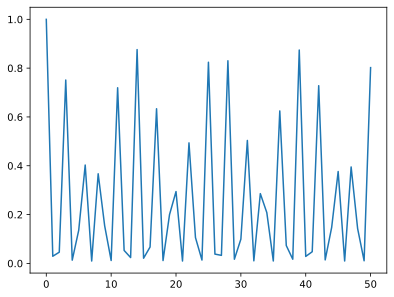

In [181]:
plt.plot(fid)

# Save data

In [130]:
data = []

In [219]:
result = {
    'amp': 0.96,
    '[dQ,dC]': [dimTransmon, dimCavity],
    'fourth_order_fit_value': solution4.x,
    'fifth_order_fit_value': solution5.x,
    'avg_fit_fid_4': avg_state_fid_4,
    'avg_fit_fid_5': avg_state_fid_5
}

data.append(result)

In [220]:
data

[{'amp': 0.0,
  '[dQ,dC]': [15, 20],
  'fourth_order_fit_value': array([-1.79104250e-04, -5.13447036e-06,  9.46105493e-08,  5.99424227e-09]),
  'fifth_order_fit_value': array([-1.71633304e-04, -8.25287514e-06,  4.25385542e-07,  7.52976843e-09,
         -3.56372812e-10]),
  'avg_fit_fid_4': 0.29632858940721535,
  'avg_fit_fid_5': 0.2963291502772414},
 {'amp': 0.12,
  '[dQ,dC]': [15, 20],
  'fourth_order_fit_value': array([-5.86444026e-04, -1.98833133e-06, -2.08773747e-07,  2.53501417e-08]),
  'fifth_order_fit_value': array([-5.87482274e-04, -7.86788993e-07, -5.38683342e-07,  4.61814243e-08,
          6.66247392e-10]),
  'avg_fit_fid_4': 0.2817580826372029,
  'avg_fit_fid_5': 0.281758407212676},
 {'amp': 0.24,
  '[dQ,dC]': [15, 20],
  'fourth_order_fit_value': array([-5.44351088e-04, -1.15133843e-06,  1.50169878e-07, -6.10742713e-09]),
  'fifth_order_fit_value': array([-5.42926672e-04, -2.02798983e-06,  3.40306607e-07, -2.18481116e-08,
          3.92274790e-10]),
  'avg_fit_fid_4': 0.269

In [221]:
import pickle
with open('./self_Kerr/data_fit.pkl', 'wb') as f:
    pickle.dump(data, f)

In [12]:
data_load = np.load('./self_Kerr/data_fit.pkl', allow_pickle=True)

In [13]:
data_load[0]['fourth_order_fit_value'][1]

-5.134470362454889e-06

In [14]:
kerr_4 = [data_load[i]['fourth_order_fit_value'][1] for i in range(len(amp_swept))]
kerr_5 = [data_load[i]['fifth_order_fit_value'][1] for i in range(len(amp_swept))]

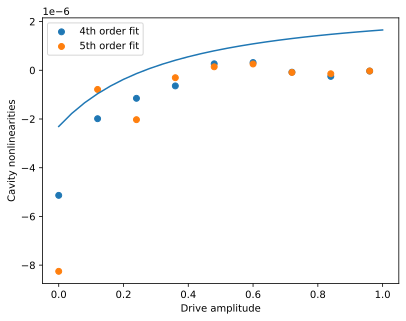

In [20]:
plt.scatter(amp_swept, kerr_4, label='4th order fit')
plt.scatter(amp_swept, kerr_5, label='5th order fit')
plt.plot(large_amps, KBs_blue_large_amp)
plt.xlabel('Drive amplitude')
plt.ylabel('Cavity nonlinearities')
plt.legend()

# Log

- We'll start again with dimension 15, 20
    - Amplitude range: `amp_swept = np.arange(0, 1, 0.12)`.
    - Fit to 3rd order, 4th order, and 5th order

- Then we'll do 20, 25, and do the same thing.